Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9820601..1.9663621].


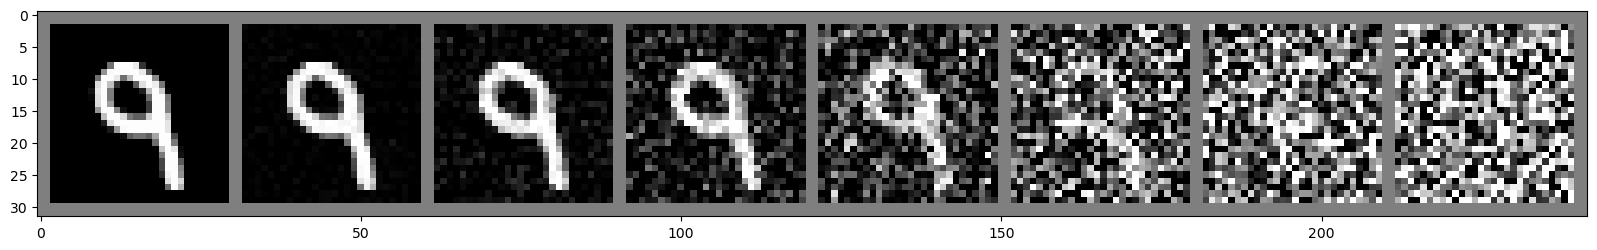

In [8]:
import utils
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import LRScheduler

sde = utils.VPSDE(T_max=1,beta_min=0.01, beta_max=10.0)
def load_mnist():
    image_size = 28
    transform = transforms.Compose([transforms.Resize(image_size),\
                                    transforms.ToTensor(),\
                                    transforms.Normalize([0.5],[0.5])]) #Normalize to -1,1
    trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
    batch_size = 256
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=2)
    return image_size, trainloader, trainset

def imshow(img):
    img = img / 2 + 0.5 
    npimg = img.numpy()
    plt.figure(figsize=[20, 20])
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
def visualize_forward_sde(X_0):
    n_time = 8
    X_0 = torch.stack([X_0]*n_time)
    time_vec = torch.linspace(0, 1, n_time)**2
    X_t, noise, score = sde.run_forward(X_0,torch.linspace(0, 1.0, n_time)**2)
    imshow(torchvision.utils.make_grid(X_t.unsqueeze(1)))

image_size, trainloader, trainset = load_mnist()
X_0 = trainset[20103][0].unsqueeze(0).squeeze()
visualize_forward_sde(X_0)


In [16]:
classes_by_index  = np.arange(0,10).tolist()
token_variables  = classes_by_index + [10]
class ChannelShuffle(nn.Module):
    def __init__(self,groups):
        super().__init__()
        self.groups=groups
    def forward(self,x):
        n,c,h,w=x.shape
        x=x.view(n,self.groups,c//self.groups,h,w) # group
        x=x.transpose(1,2).contiguous().view(n,-1,h,w) #shuffle
        
        return x

class ConvBnSiLu(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size,stride=1,padding=0):
        super().__init__()
        self.module=nn.Sequential(nn.Conv2d(in_channels,out_channels,kernel_size,stride=stride,padding=padding),
                                  nn.BatchNorm2d(out_channels),
                                  nn.SiLU(inplace=True))
    def forward(self,x):
        return self.module(x)

class ResidualBottleneck(nn.Module):
    '''
    shufflenet_v2 basic unit(https://arxiv.org/pdf/1807.11164.pdf)
    '''
    def __init__(self,in_channels,out_channels):
        super().__init__()

        self.branch1=nn.Sequential(nn.Conv2d(in_channels//2,in_channels//2,3,1,1,groups=in_channels//2),
                                    nn.BatchNorm2d(in_channels//2),
                                    ConvBnSiLu(in_channels//2,out_channels//2,1,1,0))
        self.branch2=nn.Sequential(ConvBnSiLu(in_channels//2,in_channels//2,1,1,0),
                                    nn.Conv2d(in_channels//2,in_channels//2,3,1,1,groups=in_channels//2),
                                    nn.BatchNorm2d(in_channels//2),
                                    ConvBnSiLu(in_channels//2,out_channels//2,1,1,0))
        self.channel_shuffle=ChannelShuffle(2)

    def forward(self,x):
        x1,x2=x.chunk(2,dim=1)
        x=torch.cat([self.branch1(x1),self.branch2(x2)],dim=1)
        x=self.channel_shuffle(x) #shuffle two branches

        return x

class ResidualDownsample(nn.Module):
    '''
    shufflenet_v2 unit for spatial down sampling(https://arxiv.org/pdf/1807.11164.pdf)
    '''
    def __init__(self,in_channels,out_channels):
        super().__init__()
        self.branch1=nn.Sequential(nn.Conv2d(in_channels,in_channels,3,2,1,groups=in_channels),
                                    nn.BatchNorm2d(in_channels),
                                    ConvBnSiLu(in_channels,out_channels//2,1,1,0))
        self.branch2=nn.Sequential(ConvBnSiLu(in_channels,out_channels//2,1,1,0),
                                    nn.Conv2d(out_channels//2,out_channels//2,3,2,1,groups=out_channels//2),
                                    nn.BatchNorm2d(out_channels//2),
                                    ConvBnSiLu(out_channels//2,out_channels//2,1,1,0))
        self.channel_shuffle=ChannelShuffle(2)

    def forward(self,x):
        x=torch.cat([self.branch1(x),self.branch2(x)],dim=1)
        x=self.channel_shuffle(x) #shuffle two branches

        return x

class TimeMLP(nn.Module):
    '''
    naive introduce timestep information to feature maps with mlp and add shortcut
    '''
    def __init__(self,embedding_dim,hidden_dim,out_dim):
        super().__init__()
        self.mlp=nn.Sequential(nn.Linear(embedding_dim,hidden_dim),
                                nn.SiLU(),
                               nn.Linear(hidden_dim,out_dim))
        self.act=nn.SiLU()
    def forward(self,x,t):
        t_emb=self.mlp(t).unsqueeze(-1).unsqueeze(-1)
        x=x+t_emb
  
        return self.act(x)

class ConditionMLP(nn.Module):
    '''
    naive introduce conditional informationy  to feature maps with mlp and add shortcut
    '''
    def __init__(self,embedding_dim,hidden_dim,out_dim):
        super().__init__()
        self.mlp=nn.Sequential(nn.Linear(embedding_dim,hidden_dim),
                                nn.SiLU(),
                               nn.Linear(hidden_dim,out_dim))
        self.act=nn.SiLU()
    def forward(self,x,y):
        y_emb=self.mlp(y).unsqueeze(-1).unsqueeze(-1)
        x=x+y_emb
        return self.act(x)
    
class EncoderBlock(nn.Module):
    def __init__(self,in_channels,out_channels,time_embedding_dim, cond_embedding_dim):
        super().__init__()
        self.conv0=nn.Sequential(*[ResidualBottleneck(in_channels,in_channels) for i in range(3)],
                                    ResidualBottleneck(in_channels,out_channels//2))

        self.time_mlp=TimeMLP(embedding_dim=time_embedding_dim, hidden_dim=out_channels, out_dim=out_channels//2)
        self.y_mlp=ConditionMLP(embedding_dim=cond_embedding_dim, hidden_dim=out_channels, out_dim=out_channels//2)

        self.conv1=ResidualDownsample(out_channels//2,out_channels)
    
    def forward(self,x, t=None, y=None):
        x_shortcut=self.conv0(x)
        
        if y is not None:
            x=self.y_mlp(x,y)
                    
        if t is not None:
            x=self.time_mlp(x_shortcut,t)
            
        x=self.conv1(x)

        return [x,x_shortcut]
        
class DecoderBlock(nn.Module):
    def __init__(self,in_channels,out_channels,time_embedding_dim, cond_embedding_dim):
        super().__init__()
        self.upsample=nn.Upsample(scale_factor=2,mode='bilinear',align_corners=False)
        self.conv0=nn.Sequential(*[ResidualBottleneck(in_channels,in_channels) for i in range(3)],
                                    ResidualBottleneck(in_channels,in_channels//2))

        self.time_mlp=TimeMLP(embedding_dim=time_embedding_dim,hidden_dim=in_channels,out_dim=in_channels//2)
        self.y_mlp=ConditionMLP(embedding_dim=cond_embedding_dim,hidden_dim=in_channels,out_dim=in_channels//2)

        self.conv1=ResidualBottleneck(in_channels//2,out_channels//2)

    def forward(self,x,x_shortcut,t=None, y=None):
        
        x=self.upsample(x)
        x=torch.cat([x,x_shortcut],dim=1)
        x=self.conv0(x)
        
        if y is not None:
            x=self.y_mlp(x,y)
            
        if t is not None:
            x=self.time_mlp(x,t)
            
        x=self.conv1(x)

        return x        

class Unet(nn.Module):
    '''
    simple unet design without attention
    '''
    def __init__(self, token_variables, token_embedding_dim, timesteps, time_embedding_dim, in_channels=3, out_channels=2,base_dim=32, dim_mults=[2,4,8,16], temp: float = 20.0):
        super().__init__()

        self.token_variables = set(token_variables)
        self.n_tokens = len(token_variables)
        self.token_embedding_dim = token_embedding_dim
        
        assert isinstance(dim_mults,(list,tuple))
        assert base_dim%2==0 

        channels=self._cal_channels(base_dim,dim_mults)

        self.init_conv=ConvBnSiLu(in_channels,base_dim,3,1,1)
        
        self.time_embedding=nn.Linear(timesteps,time_embedding_dim)
        self.token_embedding=torch.nn.Embedding(self.n_tokens, token_embedding_dim)

        self.encoder_blocks=nn.ModuleList([EncoderBlock(c[0],c[1],time_embedding_dim=time_embedding_dim,cond_embedding_dim=token_embedding_dim) for c in channels])
        self.decoder_blocks=nn.ModuleList([DecoderBlock(c[1],c[0],time_embedding_dim=time_embedding_dim,cond_embedding_dim=token_embedding_dim) for c in channels[::-1]])
    
        self.mid_block=nn.Sequential(*[ResidualBottleneck(channels[-1][1],channels[-1][1]) for i in range(2)],
                                        ResidualBottleneck(channels[-1][1],channels[-1][1]//2))

        self.final_conv=nn.Conv2d(in_channels=channels[0][0]//2,out_channels=out_channels,kernel_size=1)

        self.centers = nn.Parameter(torch.linspace(0,1,timesteps+1)[:-1]+0.5/timesteps,requires_grad=False)
        self.temp = temp

    def get_softmax(self, t):
        softmax_mat = F.softmax(-self.temp*torch.abs(t[:,None]-self.centers[None,:]), dim=1)
        return softmax_mat
        
    def get_time_emb(self,t):
        softmax_mat = self.get_softmax(t)
        t=self.time_embedding(softmax_mat)
        return t

    def get_cond_emb(self,y):        
        return self.token_embedding(y)
        
    def forward(self,x,t=None, y=None):
        
        x=self.init_conv(x)
        
        if t is not None:
            t = self.get_time_emb(t)

        if y is not None:
            y = self.get_cond_emb(y)
            
        encoder_shortcuts=[]
        for encoder_block in self.encoder_blocks:
            x,x_shortcut=encoder_block(x,t=t,y=y)
            encoder_shortcuts.append(x_shortcut)
        x=self.mid_block(x)
        encoder_shortcuts.reverse()
        for decoder_block,shortcut in zip(self.decoder_blocks,encoder_shortcuts):
            x=decoder_block(x,shortcut,t=t, y=y)
        x=self.final_conv(x)
        return x

    def _cal_channels(self,base_dim,dim_mults):
        dims=[base_dim*x for x in dim_mults]
        dims.insert(0,base_dim)
        channels=[]
        for i in range(len(dims)-1):
            channels.append((dims[i],dims[i+1])) # in_channel, out_channel

        return channels
    
model = Unet(token_variables=token_variables, base_dim=image_size, in_channels=1, out_channels=1, token_embedding_dim=256, time_embedding_dim=256, timesteps=100, dim_mults=[2, 4], temp=100.0)
# model = torch.compile(model)
LEARNING_RATE = 1e-2 #2e-5
WEIGHT_DECAY = 0.0
N_EPOCHS = 100
RETRAIN = True
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TRAIN_SCORE = False 

def train_clfree_guidance(model, sde: utils.ItoSDE, dataloader: DataLoader, optimizer, device, n_epochs: int, print_every: int, scheduler: LRScheduler = None, p_uncond: float = 0.5, p_uncond_label: int = 10, train_score: bool = False):
    
    model.train()
    model = model.to(DEVICE)
    running_loss_list = []
    lr_list = []
    loss_function = nn.MSELoss(reduction='mean')

    for epoch in range(n_epochs):
        print(f"Epoch: {epoch}")
        running_loss = 0.0
        for idx, (x_inp,target) in enumerate(dataloader):

            #Randomly change labels to unconditional with probability p_uncond:
            random_uncond_mask = (torch.rand(size=(len(x_inp),))<=p_uncond)
            target[random_uncond_mask] = p_uncond_label

            #Zero gradients:
            optimizer.zero_grad()
            
            #Run forward samples:
            X_t,noise,score,time = sde.run_forward_random_time(x_inp)

            #Send to device:
            X_t = X_t.to(device)
            noise = noise.to(device)
            time = time.to(device)
            target = target.to(device)
            
            #Predict score:
            model_pred = model(x=X_t, t=time, y=target)

            #Compute loss:
            if train_score:
                loss = loss_function(score,model_pred)
            else:
                loss = loss_function(noise,model_pred)

            #Optimize:
            loss.backward()
            optimizer.step()

            if scheduler is not None:
                scheduler.step()
                
            # print statistics
            running_loss += loss.detach().item()
            
            if (idx+1) % print_every == 0:
                avg_loss = running_loss/print_every
                running_loss_list.append(avg_loss)
                running_loss = 0.0
                if scheduler is not None:
                    print(f"Loss: {avg_loss:.4f} | {scheduler.get_lr()}")
                    lr_list.append(scheduler.get_lr())
                else:
                    print(f"Loss: {avg_loss:.4f}")

                
    return model,running_loss_list

if RETRAIN:
    optimizer = torch.optim.AdamW(model.parameters(),lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY,maximize=False)
    scheduler=torch.optim.lr_scheduler.OneCycleLR(optimizer,LEARNING_RATE,total_steps=N_EPOCHS*len(trainloader),pct_start=0.25,anneal_strategy='cos')
    
    model,running_loss_list = train_clfree_guidance(model, sde, trainloader, train_score=TRAIN_SCORE, optimizer=optimizer, scheduler=scheduler, device=DEVICE, n_epochs=N_EPOCHS, print_every=100)
    torch.save(model.state_dict(),"mnist_diffusion_denoiser_full_training.ckpt")
    
else:
    model_state_dict = torch.load("mnist_diffusion_denoiser_full_training.ckpt")
    model.load_state_dict(model_state_dict)

Epoch: 0


KeyboardInterrupt: 

In [13]:
for idx, batch in enumerate(trainloader):
    break
x = batch[0]
y = batch[1]
t = torch.rand(len(y))

print("x.shape: ", x.shape)
print("y.shape: ", y.shape)
print("t.shape: ", t.shape)

output = model(x,t=t,y=y)

print("output.shape: ", output.shape)

x.shape:  torch.Size([256, 1, 28, 28])
y.shape:  torch.Size([256])
t.shape:  torch.Size([256])
output.shape:  torch.Size([256, 1, 28, 28])
